# AB test

In [3]:
# pip install firebase_admin

In [5]:
import json
import pandas as pd
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db

cred = credentials.Certificate('../../.Import/project-otaku.json')
f = open('../../.Import/dburl.json')
dburl = json.load(f)
f.close()

firebase_admin.initialize_app(cred, dburl)

### Check collected Data

In [6]:
dbdir = db.reference('user_sessions')
display(pd.DataFrame(dbdir.get()).T.tail())

dbdir = db.reference('query')
display(pd.DataFrame(dbdir.get()).T.tail())

dbdir = db.reference('test')
display(pd.DataFrame(dbdir.get()).T.tail())

,abtest_id,session_id,timestamp
-N8H0jwvEEoLjRdbDGsT,0,343,2022-07-31 02:12:46.512012
-N8HTpKDD--cNiGVZ3Js,1,344,2022-07-31 04:19:50.723285
-N8JiKVwR12WnGrh-7oH,1,345,2022-07-31 14:46:49.079537
-N8JiYQqJz3wbFlfowZ-,0,347,2022-07-31 14:47:46.061073
-N8OgRDK83OLc6tp-smo,0,348,2022-08-01 13:56:38.396319


,query,session_id,timestamp
-N8HU1R-IjzuowCnR99G,30012,344,2022-07-31 04:20:44.387100
-N8HUVm-9RIVDp-YSEGs,30336,344,2022-07-31 04:22:48.673933
-N8JimgMQiYTC-y1uwoA,5114,347,2022-07-31 14:48:48.569632
-N8OgXSsC0CSuQNTL-rP,30002,348,2022-08-01 13:57:03.976834
-N8Ogb47cGf_d_Id-IC8,30051,348,2022-08-01 13:57:22.858340


,abtest_id,relevant_index,session_id,timestamp,title_id
-N8HURmfpm7Lt0tb2zTp,1,47,344,2022-07-31 04:22:32.319278,30022
-N8HUXcXuLdO63t1_xy5,1,4,344,2022-07-31 04:22:56.276033,30047
-N8HUYU8qRUATcgowCpe,1,6,344,2022-07-31 04:22:59.758970,30021
-N8HU_9Ie444j4FCCOJh,1,12,344,2022-07-31 04:23:06.629802,30051
-N8Ogp26a_Tb2J4B0op7,0,2,348,2022-08-01 13:58:20.068129,33367


### Calculating mAP from user click data

In [7]:
dbdir = db.reference('test')
test_list = pd.DataFrame(dbdir.get()).T.loc[lambda x : (x.session_id.astype(int) >= 291) & (x.session_id.astype(int) < 348)]
test_list.head()

,abtest_id,relevant_index,session_id,timestamp,title_id
-N86SI9L8LuEuO49sWqt,0,1,291,2022-07-29 00:57:19.240547,21730
-N86SKFbvcE8NOr3UmIQ,0,5,291,2022-07-29 00:57:27.813282,1651
-N86SLi7vEbjqJB5YUPE,0,6,291,2022-07-29 00:57:33.807662,396
-N86SOnUL6l0P-oTRubv,0,18,291,2022-07-29 00:57:46.435353,290
-N86VMxCEleiKLZCh62_,1,4,294,2022-07-29 01:10:45.309073,85611


In [8]:
map_list = test_list.groupby(['session_id','abtest_id']).agg({'relevant_index':set})
map_list.relevant_index.to_frame().head()

,,relevant_index
session_id,abtest_id,
291,0,"{18, 5, 6, 1}"
294,1,"{5, 4}"
295,1,{12}
298,0,"{10, 18, 6, 4, 15, 12}"
301,1,"{4, 11, 1}"


In [9]:
def eval_map(relevant_idx):
    """
    calculating mAP from index numbers of relevant titles
    """
    relevant_idx.sort()

    total_ap = 0
    for idx, rel_idx  in enumerate(relevant_idx):
        total_ap += (idx + 1)/rel_idx
    return total_ap/len(relevant_idx)

In [10]:
from ast import literal_eval

map_list['map'] = map_list.relevant_index.apply(list).apply(lambda x : eval_map(list(map(int,x))))
map_list.head()

,,relevant_index,map
session_id,abtest_id,,
291,0,"{18, 5, 6, 1}",0.530556
294,1,"{5, 4}",0.325000
295,1,{12},0.083333
298,0,"{10, 18, 6, 4, 15, 12}",0.313889
301,1,"{4, 11, 1}",0.590909


### Calculating conversion rate from user click data

In [12]:
dbdir = db.reference('query')
query_list = pd.DataFrame(dbdir.get()).T.loc[lambda x : (x.session_id.astype(int) >= 291) & (x.session_id.astype(int) < 348)][['session_id']].drop_duplicates()
query_list.head()

,session_id
-N86SCwk8VdyaqRTZw9y,291
-N86U1imJBMFgMWl4G1P,292
-N86Uq_osw1sCs6KJuUU,294
-N86XbuRWDsX9WQ61SNH,295
-N86clMiJT-b1yFhN1Lx,296


In [13]:
dbdir = db.reference('user_sessions')
session_list = pd.DataFrame(dbdir.get()).T.loc[lambda x : (x.session_id.astype(int) >= 291) & (x.session_id.astype(int) < 348)][['session_id','abtest_id']]
session_list.reset_index(drop = True).head()

,session_id,abtest_id
0,291,0
1,292,0
2,293,0
3,294,1
4,295,1


In [14]:
query_list.session_id = query_list.session_id.astype(int)
session_list.session_id = session_list.session_id.astype(int)
ql = query_list.merge(session_list, how = 'left', on = 'session_id')
ql.head()

,session_id,abtest_id
0,291,0
1,292,0
2,294,1
3,295,1
4,296,0


In [15]:
ml = map_list.reset_index()
ml.session_id = ml.session_id.astype(int)
ql['converted'] = ql.session_id.apply(lambda x : 1 if x in list(ml.session_id) else 0)
ql.head()

,session_id,abtest_id,converted
0,291,0,1
1,292,0,0
2,294,1,1
3,295,1,1
4,296,0,0


In [43]:
complete_test = ql.merge(ml.drop('abtest_id', axis = 1), how = 'left', on = 'session_id')
complete_test.map = complete_test.map.fillna(0)

In [17]:
complete_test.head()

,session_id,abtest_id,converted,relevant_index,map
0,291,0,1,"{18, 5, 6, 1}",0.530556
1,292,0,0,NaN,0.000000
2,294,1,1,"{5, 4}",0.325000
3,295,1,1,{12},0.083333
4,296,0,0,NaN,0.000000


### Interpreting the result

In [19]:
# data info

print(f'number of sessions collected: {len(session_list)}')
print(f'number of sessions where users selected fav titles: {len(query_list)}')
print(f'number of sessions converted(hit ❤️ buttons): {len(complete_test.loc[lambda x : x.converted == 1])}')

number of sessions collected: 56
number of sessions where users selected fav titles: 42
number of sessions converted(hit ❤️ buttons): 30


In [20]:
# abtest_id portion

abtest_id = complete_test['abtest_id'].value_counts(normalize = True).to_frame()
abtest_id = pd.concat([abtest_id, complete_test['abtest_id'].value_counts().to_frame()], axis = 1)
abtest_id.index = ['CBF', 'UBF']
abtest_id.columns = ['percentage','num_of_samples']


abtest_id

,percentage,num_of_samples
CBF,0.5,21
UBF,0.5,21


In [21]:
# converted_ratio by abtest_id

converted = complete_test.groupby('abtest_id').converted.mean().to_frame()
converted = pd.concat([converted, complete_test.groupby('abtest_id').converted.sum().to_frame()], axis = 1)
converted.index = ['CBF','UBF']
converted.columns = ['conversion_rate','num_of_samples_converted']

converted

,conversion_rate,num_of_samples_converted
CBF,0.761905,16
UBF,0.666667,14


In [22]:
# mAP by abtest_id
mAP = complete_test.groupby('abtest_id').map.mean().to_frame()
mAP.index = ['CBF','UBF']

mAP

,map
CBF,0.402694
UBF,0.301160


In [25]:
# pip install pingouin

In [28]:
from pingouin import ttest, mwu

a = complete_test.loc[lambda x : x.abtest_id == '0'].map
b = complete_test.loc[lambda x : x.abtest_id == '1'].map

In [29]:
ttest(a,b)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.974922,40,two-sided,0.335458,"[-0.11, 0.31]",0.300867,0.443,0.15845


**independent t test result:** sample size too small to conduct t test / sample distribution does not meet the assumptions for conducting t test

In [30]:
mwu(a,b)

,U-val,alternative,p-val,RBC,CLES
MWU,258.0,two-sided,0.346306,-0.170068,0.585034


**mann-whitney U test result:** conducted non-parametric test since the samples do not meet the requirement for t test

**No statistically significant difference(in terms of conversion rate/mAP) between the two methods.**

In [33]:
from scipy import stats

In [31]:
total_counts = ql.abtest_id.value_counts()
converted_sum = ql.groupby('abtest_id').converted.sum()
conv_mat = pd.concat([total_counts,converted_sum], axis = 1)
converted = conv_mat.values
conv_mat.index = ['CBF','UBF']
conv_mat

,abtest_id,converted
CBF,21,16
UBF,21,14


**test for difference in conversion rate:** chi squared test

In [34]:
result = stats.chi2_contingency(converted)
print(f'Xsquared : {round(result[0],4)}, P-value : {round(result[1],4)}')

Xsquared : 0.0016, P-value : 0.9682


Text(0.5, 1.0, 'distribution of mAP for both methods')

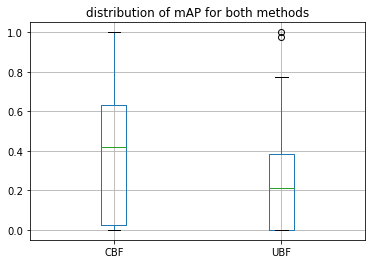

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

complete_test.abtest_id = complete_test.abtest_id.apply(lambda x : 'CBF' if x == '0' else 'UBF')
ax = pd.pivot(complete_test, index = 'session_id', columns = 'abtest_id', values = 'map').boxplot()
plt.title('distribution of mAP for both methods')